# VAR with fixed coefficients in *statsmodels*

Simulate a VAR(1) model with fixed parameters and estimate the model to recover coefficients of data-generating process.

Links:
 - statsmodels [statespace.varmax](https://www.statsmodels.org/stable/generated/statsmodels.tsa.statespace.varmax.VARMAX.html) and [statespace.varmax.simulate](https://www.statsmodels.org/stable/generated/statsmodels.tsa.statespace.varmax.VARMAX.simulate.html) to simulate data
 - statsmodels [vector_ar.var_model.VAR](https://www.statsmodels.org/stable/generated/statsmodels.tsa.vector_ar.var_model.VAR.html) to estimate VAR model
 - [Estimating or specifying parameters in state space models](https://www.statsmodels.org/devel/examples/notebooks/generated/statespace_fixed_params.html).

Notebook by @VilleEcon.

In [1]:
import statsmodels.api as sm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.stats.moment_helpers import corr2cov
np.random.seed(5000)

Data-generating VAR(1) process reads

$
\begin{align*}
Y_{1,t} & = \beta_{1,0} + \beta_{1,1} Y_{1,t-1} + \beta_{1,2} Y_{2,t-1} + \epsilon_{1,t} \\
Y_{2,t} & = \beta_{2,0} + \beta_{2,1} Y_{1,t-1} + \beta_{2,2} Y_{2,t-1} + \epsilon_{2,t} \\
\end{align*}
$

with coefficient matrix

$
\begin{align*}
\mathbf{B} = \begin{bmatrix} \beta_{1,0} & \beta_{1,1} & \beta_{1,2} \\ \beta_{2,0} & \beta_{2,1} & \beta_{2,2} \end{bmatrix} =
\begin{bmatrix} 0 & 0.8 & 0.5 \\ 3 & -0.2 & 0.1 \end{bmatrix}
\end{align*}
$

Errors $\epsilon_{1,t}, \epsilon_{2,t}$ follow multivariate normal dsitribution with covariance matrix

$
\begin{align*}
\mathbf{\Sigma} = \begin{bmatrix} 1 & 0.4 \\ 0.4 & 1 \end{bmatrix} ,
\end{align*}
$

meaning that $Corr(\epsilon_{1,t}, \epsilon_{2,t}) = 0.2$.

Specify needed parameters:

In [2]:
# Simulation periods
T = 300

# Intercepts
intercepts = np.array(
    [0, 3], #beta_01, beta_02
)

# Coefficients
coefs = np.array([
       [0.8, 0.5], # mu1, beta_11, beta_12, 
       [-0.2, 0.1], # mu2, beta_21, beta_22
]).flatten(order="C")

# Correlation matrix of errors
corr = np.array([
    [1, 0.2],
    [0.2, 1],
])

# Standard deviation of errors
stds = [1, 1] # std(e_1t), std(e_2t)

Build model and assign parameter values:

In [3]:
# Statsmodels classes read number of variables from the shape of endogenous array, so even if
# we do not have such a thing we pass in a dummy array with column shape of 2
endog = np.array([[ None,  None]])

# VAR model object
mod1 = sm.tsa.VARMAX(endog, order=(1, 0))
print(f"Parameters in order: {*mod1.param_names,}")

# Transform corerlation to covariance
cov = corr2cov(corr, stds)

# Concatenate parameters into 1D array
params = np.concatenate([intercepts, coefs, cov[np.triu_indices(cov.shape[1])]], axis=0)

print(f"Fixed values: {*params,}")

Parameters in order: ('intercept.y1', 'intercept.y2', 'L1.y1.y1', 'L1.y2.y1', 'L1.y1.y2', 'L1.y2.y2', 'sqrt.var.y1', 'sqrt.cov.y1.y2', 'sqrt.var.y2')
Fixed values: (0.0, 3.0, 0.8, 0.5, -0.2, 0.1, 1.0, 0.2, 1.0)


Simulate data from the model and plot obtained series:

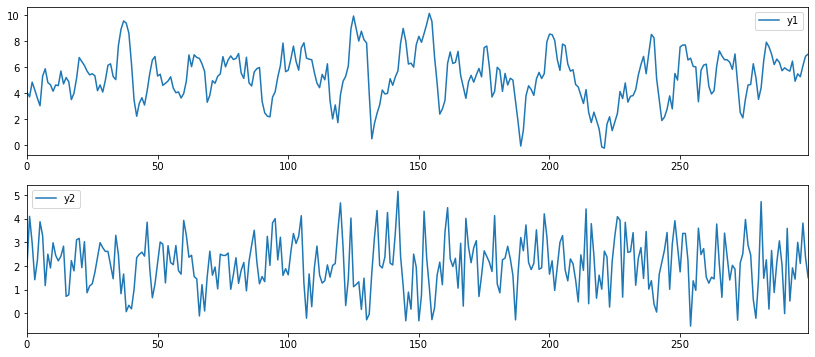

In [4]:
df = pd.DataFrame(mod1.simulate(params, T), columns=["y1", "y2"])
fig = plt.figure(figsize=(14, 6))
for idx, col in enumerate(df.columns):
    ax = fig.add_subplot(len(df.columns), 1, idx+1)
    df[[col]].plot(ax=ax)

Estimate VAR(1) model on simulated data to recover estimates for data-generating process parameters. With 300 simulated observations the estimates are not perfect.

In [5]:
mod2 = sm.tsa.VAR(df)
res = mod2.fit(maxlags=1)
res.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Thu, 20, Aug, 2020
Time:                     16:17:16
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                  0.0673166
Nobs:                     299.000    HQIC:                 0.0227810
Log likelihood:          -841.488    FPE:                   0.993086
AIC:                  -0.00693983    Det(Omega_mle):        0.973453
--------------------------------------------------------------------
Results for equation y1
           coefficient       std. error           t-stat            prob
------------------------------------------------------------------------
const        -0.346443         0.227380           -1.524           0.128
L1.y1         0.875612         0.031291           27.983           0.000
L1.y2         0.486364         0.052701            9.229           0.000

Results for equation 